In [1]:
!nvidia-smi


Tue Aug  9 14:24:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 13%   46C    P8    29W / 260W |     73MiB / 11011MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import os
import shutil
import random


In [9]:
base_path = "./data/"
raw_path = os.path.join(base_path, "aug_artery/aug_img/0/")
mask_path = os.path.join(base_path, "aug_artery/aug_mask/0/")
data_file_lists = [fpath for fpath in os.listdir(raw_path) if os.path.isfile(os.path.join(raw_path, fpath))]
random.shuffle(data_file_lists)

# train validation test
us_data_base_path = './data/us-bmod/'
us_data_set_names = ['train', 'validation', 'test']
us_data_split_ratio = [6, 2, 2]


In [14]:
# split
us_data_total_len = len(data_file_lists)
us_data_split_len = [
    int(us_data_total_len * us_data_split_ratio[0] / sum(us_data_split_ratio)),
    int(us_data_total_len * us_data_split_ratio[1] / sum(us_data_split_ratio))
]
us_data_split_len.append(us_data_total_len - sum(us_data_split_len))

start_idx = 0
for us_data_len, us_data_set_name in zip(us_data_split_len, us_data_set_names):
    dst_base_path = os.path.join(us_data_base_path, us_data_set_name)
    dst_raw_path = dst_base_path + '/raw/0/'
    os.makedirs(dst_raw_path, exist_ok=True)
    dst_mask_path = dst_base_path + '/mask/0/'
    os.makedirs(dst_mask_path, exist_ok=True)
    
    for file_path in data_file_lists[start_idx:start_idx+us_data_len]:
        # copy raw
        src_file_path = os.path.join(raw_path, file_path)
        dst_file_path = os.path.join(dst_raw_path, file_path)
        shutil.copyfile(src_file_path, dst_file_path)
        # print(src_file_path, dst_file_path)        
        # move mask
        src_file_path = os.path.join(mask_path, file_path)
        dst_file_path = os.path.join(dst_mask_path, file_path)
        shutil.copyfile(src_file_path, dst_file_path)
        # print(src_file_path, dst_file_path)        
    start_idx += us_data_len

In [2]:
from UNetKerasMod import UNet
import copy
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import time
os.environ [ "TF_FORCE_GPU_ALLOW_GROWTH" ] = "true"

2022-08-09 14:25:10.371542: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/home/j/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
batch_size = 4
img_size = (512, 512)
in_dim = 3
out_dim = 1
num_filters = 16
epochs=100

In [4]:

def DataGenerator(data_gen_args, path, random_seed, target_size, batch_size, color_mode='rgb', subset='training'):
    image_gen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
    data_gen = image_gen.flow_from_directory(path, class_mode=None, target_size=target_size, color_mode=color_mode, shuffle=True, seed=random_seed, batch_size=batch_size, subset=subset)
    return data_gen

In [5]:
# y = DataGenerator(path, random_seed=1, is_categorical=True, threshold=250, color_mode=0)
# data_gen_args = dict(
#     rescale=1./255,
#         #                     featurewise_center=True,
#         #                     featurewise_std_normalization=True,
#         #                 rotation_range=30,
#         #                 width_shift_range=0.1,
#         #                 height_shift_range=0.1,
#         #                 zoom_range=0.2)
# )
data_gen_args = dict(
    rescale=1./255,
)
# dataset_type = ['train', 'validation', 'test']
raw_data_path = "./data/us-bmod/{}/raw"
mask_data_path = "./data/us-bmod/{}/mask"

x_train = DataGenerator(data_gen_args, raw_data_path.format('train'), random_seed=1, target_size=img_size, batch_size=batch_size)
x_validation = DataGenerator(data_gen_args, raw_data_path.format('validation'), random_seed=1, target_size=img_size, batch_size=batch_size)
x_test = DataGenerator(data_gen_args, raw_data_path.format('test'), random_seed=1, target_size=img_size, batch_size=batch_size)

data_gen_args = dict(
    rescale=1./255,
    preprocessing_function = lambda x: np.where(x>0, 255, 0).astype(x.dtype)
)
y_train = DataGenerator(data_gen_args, mask_data_path.format('train'), random_seed=1, target_size=img_size, color_mode='grayscale', batch_size=batch_size)
y_validation = DataGenerator(data_gen_args, mask_data_path.format('validation'), random_seed=1, target_size=img_size, color_mode='grayscale', batch_size=batch_size)
y_test = DataGenerator(data_gen_args, mask_data_path.format('test'), random_seed=1, target_size=img_size, color_mode='grayscale', batch_size=batch_size)

data_generator_train = zip(x_train, y_train)
data_generator_validation = zip(x_validation, y_validation)
data_generator_test = zip(x_test, y_test)

Found 483 images belonging to 1 classes.
Found 161 images belonging to 1 classes.
Found 161 images belonging to 1 classes.
Found 483 images belonging to 1 classes.
Found 161 images belonging to 1 classes.
Found 161 images belonging to 1 classes.


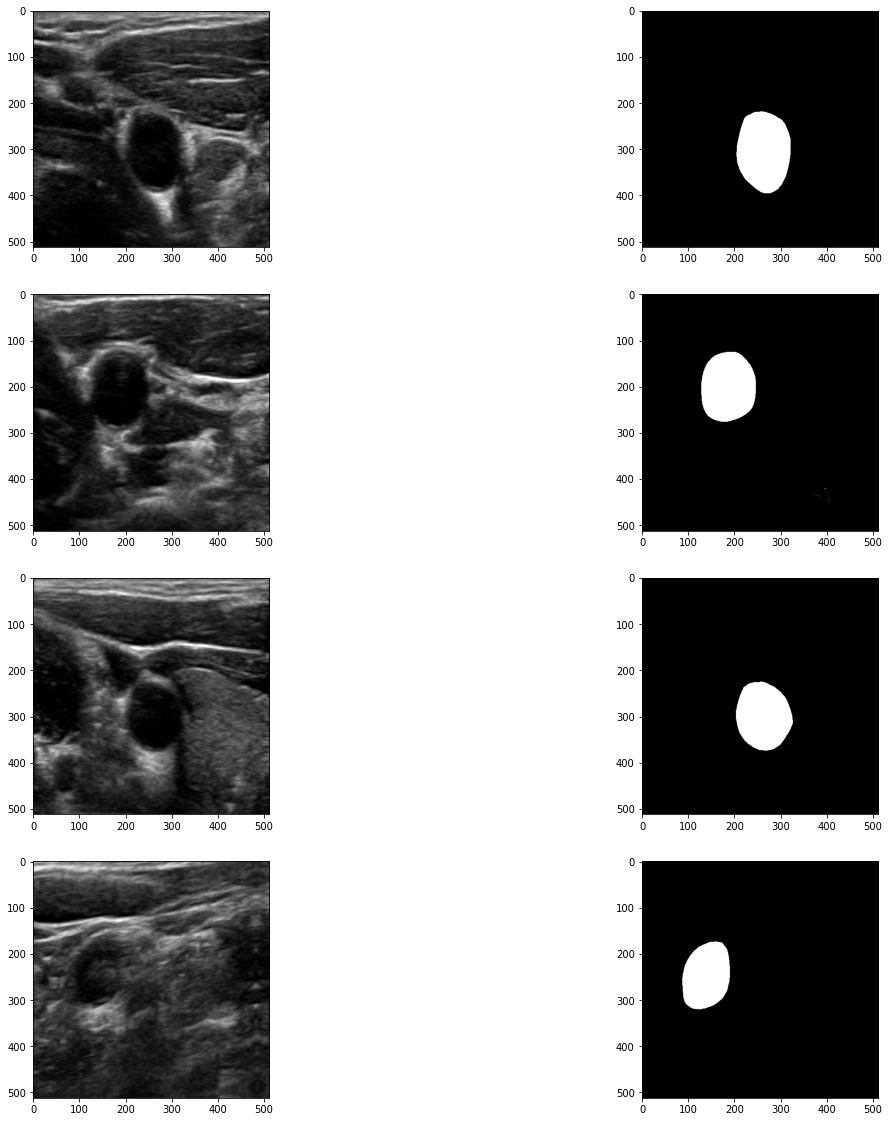

In [6]:
for i, (image_data, mask_data) in enumerate(data_generator_train):
    fig = plt.figure(figsize=(20,20))
    for j in range(len(image_data)):
        fig.add_subplot(len(image_data),2,j*2+1)
        plt.imshow((image_data[j]*255).astype(np.uint8) ,cmap='gray')
        # print(np.unique(image_data[j]*255))
        # print(np.unique(mask_data[j]))
        fig.add_subplot(len(image_data),2,j*2+2)
        plt.imshow((mask_data[j]*255).astype(np.uint8), cmap='gray')
    plt.show()
    break

In [9]:
for i in range(0, 5):
    model_file_name = "./checkpoint-epoch-{epoch:04d}-" + time.strftime("%y%m%d-%H%M") + "maxpool_{}th-compression".format(i) + "-512.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        model_file_name,
        monitor='binary_crossentropy',  
        verbose=1,            # 로그를 출력합니다
        save_best_only=True,  # 가장 best 값만 저장합니다
    #     save_weight_only=True,
        mode='auto'
    )
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='binary_crossentropy', patience=5)
    if i == 0:
        model = UNet(3,1,16, [])
    else:
        model = UNet(3,1,16, [i])
    batch_size = 4
    img_size = (512,512)
    model.build(input_shape=(batch_size,img_size,3))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['binary_crossentropy'])
    model.fit(data_generator_train, epochs=50, steps_per_epoch=len(x_train)-1, callbacks=[checkpoint, early_stop], validation_data=data_generator_validation, validation_steps=50)


Epoch 1/50
120/120 [==============================] - 30s 243ms/step - loss: 0.7017 - binary_crossentropy: 0.7017 - val_loss: 0.6096 - val_binary_crossentropy: 0.6096

Epoch 00001: binary_crossentropy improved from inf to 0.65559, saving model to ./checkpoint-epoch-0001-220809-1428maxpool_0th-compression-512.h5
Epoch 2/50
120/120 [==============================] - 28s 233ms/step - loss: 0.5028 - binary_crossentropy: 0.5028 - val_loss: 0.5764 - val_binary_crossentropy: 0.5764

Epoch 00002: binary_crossentropy improved from 0.65559 to 0.46402, saving model to ./checkpoint-epoch-0002-220809-1428maxpool_0th-compression-512.h5
Epoch 3/50
120/120 [==============================] - 28s 237ms/step - loss: 0.3476 - binary_crossentropy: 0.3476 - val_loss: 0.3848 - val_binary_crossentropy: 0.3848

Epoch 00003: binary_crossentropy improved from 0.46402 to 0.33758, saving model to ./checkpoint-epoch-0003-220809-1428maxpool_0th-compression-512.h5
Epoch 4/50
120/120 [==============================] -

KeyboardInterrupt: 

(512, 512, 1)
[7.6117863e-07 7.6162223e-07 9.3711515e-07 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


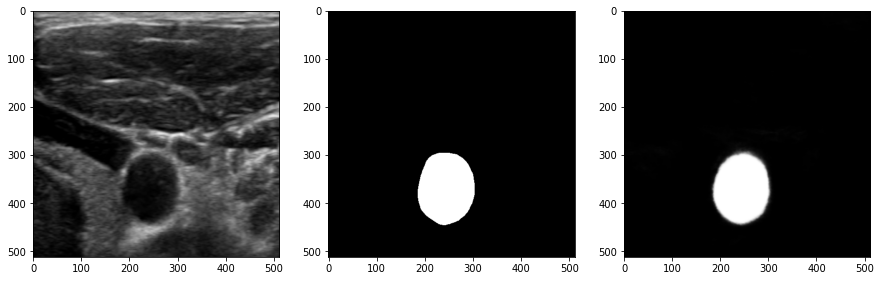

[0. 1.]
(512, 512, 1)
[6.5423651e-06 6.8369254e-06 6.8463405e-06 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


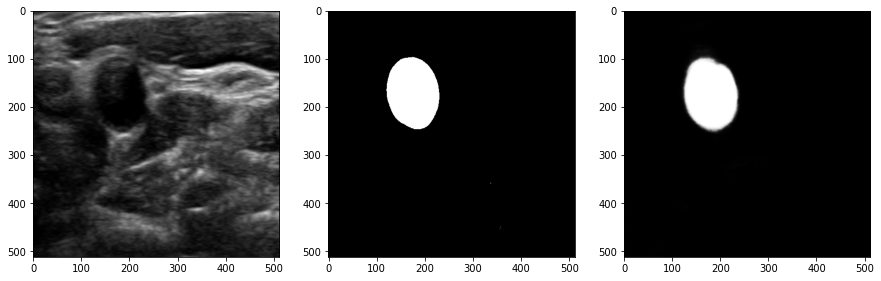

[0. 1.]
(512, 512, 1)
[2.0966199e-06 2.1025569e-06 2.1343396e-06 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


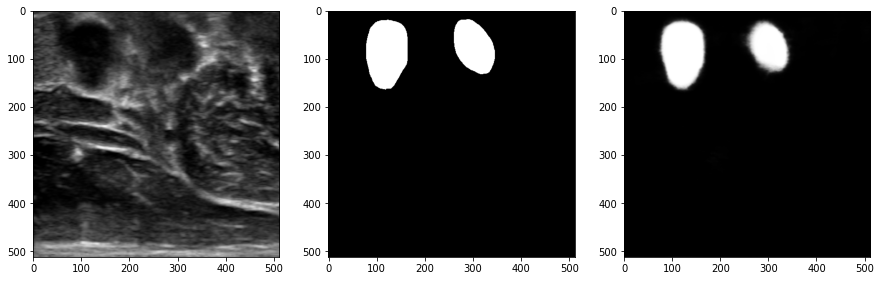

[0. 1.]
(512, 512, 1)
[2.6018695e-05 2.6411284e-05 2.7404967e-05 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


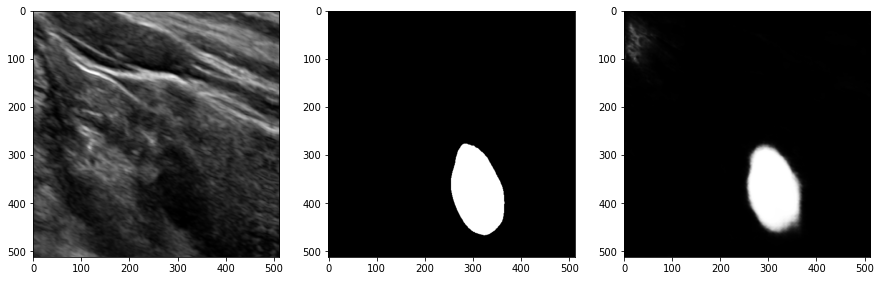

[0. 1.]
(512, 512, 1)
[2.1700936e-05 2.2741366e-05 2.3624558e-05 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


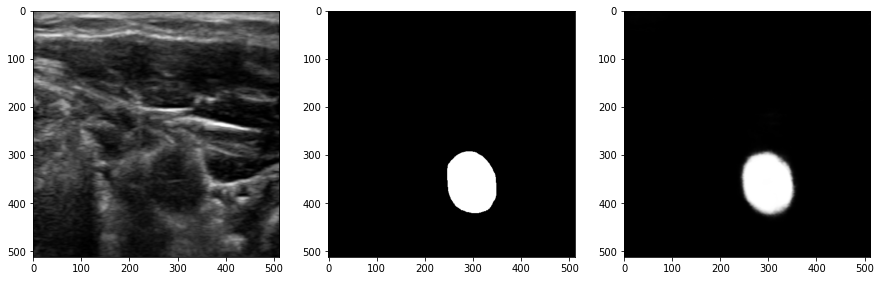

[0. 1.]
(512, 512, 1)
[2.0515863e-06 2.0782834e-06 2.1176857e-06 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


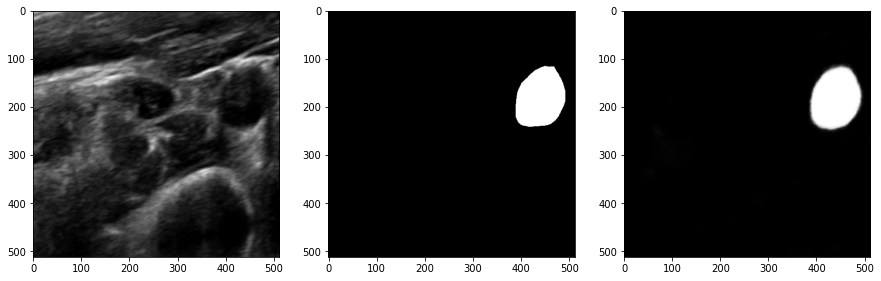

[0. 1.]


In [14]:
# test
for i, (image_data, mask_data) in enumerate(data_generator):
    fig = plt.figure(figsize=(15,15))
    fig.add_subplot(1,3,1)
    plt.imshow((image_data[0]*255).astype(np.uint8) ,cmap='gray')
    fig.add_subplot(1,3,2)
    plt.imshow((mask_data[0]).astype(np.uint8), cmap='gray')
    fig.add_subplot(1,3,3)
    result = model.predict(image_data)
    pred_mask = result[0]
    print(pred_mask.shape)
    print(np.unique(pred_mask))
    plt.imshow((np.array(pred_mask*255)).astype(np.uint8), cmap='gray')
#     plt.imshow((result[0][:,:,1]*255).astype(np.uint8), cmap='gray')
#     print(np.unique(result[0][:,:,1]))
    plt.show()
    print(np.unique(mask_data))
    if i == 5:
        break